In [1]:
# pip install opencv-python
#pip install imutils


import os
import zipfile
import random
import shutil
import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau
from shutil import copyfile
from os import getcwd
from os import listdir
import cv2
from tensorflow.keras.layers import Conv2D, Input, ZeroPadding2D, BatchNormalization, Activation, MaxPooling2D, Flatten, Dense
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.utils import shuffle
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import imutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image  as mpimg
import argparse
import csv
import pandas as pd


2023-07-24 15:33:36.616099: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-24 15:33:37.096532: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-07-24 15:33:38.149944: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/guilherme/cpu-tensorflow-marcelo/nvidia-smi/envs/tf/lib/
2023-07-24 15:33:38.151958: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7';

In [2]:

# initialize the initial learning rate, number of epochs to train for,
# and batch size
INIT_LR = 1e-4 # mais um parâmetro para teste
#EPOCHS = 100
EPOCHS_DEFAULT = 15
BS_DEFAULT = 32
# batch-size
BS = 32
EPOCHS_PARAM = EPOCHS_DEFAULT

plot_output_file = "plot.png"

model_name = "mask_detector_model"

In [3]:
# construct the argument parser and parse the arguments
ap = argparse.ArgumentParser()
#ap.add_argument("-d", "--dataset", required=True,
#	help="path to input dataset")
ap.add_argument("-p", "--plot", type=str, default="plot.png",
	help="path to output loss/accuracy plot")
ap.add_argument("-m", "--model", type=str,
	default="mask_detector.model",
	help="path to output face mask detector model")
ap.add_argument("-e", "--epochs", type=int,
	default="30",
	help="quantity of epochs to learning")
ap.add_argument("-bs", "--batch_size", type=int,
	default="32",
	help="batch size")
ap.add_argument("-lr", "--learning_rate", type=int,
	default="-1",
	help="Learning rate [from 0.0 to 1.0]")
args = vars(ap.parse_args())

usage: ipykernel_launcher.py [-h] [-p PLOT] [-m MODEL] [-e EPOCHS]
                             [-bs BATCH_SIZE] [-lr LEARNING_RATE]
ipykernel_launcher.py: error: unrecognized arguments: -f /home/guilherme/.local/share/jupyter/runtime/kernel-5de150ae-35b7-4b4d-b603-f840ea05c3b3.json


SystemExit: 2

/home/guilherme/cpu-tensorflow-marcelo/nvidia-smi/envs/tf/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3441: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [3]:
# argumentos
#EPOCHS_PARAM = args['epochs']
#BS = args['batch_size']

#if(args['learning_rate'] > 0.0):
#    INIT_LR = args['learning_rate']

In [4]:
def data_summary(main_path):
    
    yes_path = main_path+'with_mask'
    no_path = main_path+'without_mask'
        
    # number of files (images) that are in the the folder named 'yes' that represent tumorous (positive) examples
    m_pos = len(listdir(yes_path))
    # number of files (images) that are in the the folder named 'no' that represent non-tumorous (negative) examples
    m_neg = len(listdir(no_path))
    # number of all examples
    m = (m_pos+m_neg)
    
    pos_prec = (m_pos* 100.0)/ m
    neg_prec = (m_neg* 100.0)/ m
    
    print("-------------------------------------------------")
    print("-------------------------------------------------")
    print("-------------------------------------------------")
    print("[INFO] Number of examples: {",m,"}")
    print("[INFO] Percentage of positive examples: {",pos_prec,"}, number of pos examples: {",m_pos,"}") 
    print("[INFO] Percentage of negative examples: {",neg_prec,"}, number of neg examples: {",m_neg,"}") 
    print("-------------------------------------------------")
    print("-------------------------------------------------")
    print("-------------------------------------------------")

In [5]:
#augmented_data_path = 'facemask-dataset/trial1/augmented data1/' 
#augmented_data_path = 'data/'  
#augmented_data_path = 'facemask-rodolfo/FaceMaskDataSet/' 
augmented_data_path = 'data/' 
# observations-master/experiements/test/
data_summary(augmented_data_path)

-------------------------------------------------
-------------------------------------------------
-------------------------------------------------
[INFO] Number of examples: { 2476 }
[INFO] Percentage of positive examples: { 48.66720516962843 }, number of pos examples: { 1205 }
[INFO] Percentage of negative examples: { 51.33279483037157 }, number of neg examples: { 1271 }
-------------------------------------------------
-------------------------------------------------
-------------------------------------------------


In [6]:
print("[INFO] prepering training images...")

TRAINING_DIR = augmented_data_path+"train"

train_datagen = ImageDataGenerator(rescale=1.0/255,
                                   rotation_range=40,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   fill_mode='nearest')

train_generator = train_datagen.flow_from_directory(TRAINING_DIR, 
                                                    batch_size=BS, 
                                                    target_size=(224, 224))
                            

[INFO] prepering training images...
Found 2341 images belonging to 2 classes.


In [7]:
print("[INFO] prepering test images...")

VALIDATION_DIR = augmented_data_path+"test"

validation_datagen = ImageDataGenerator(rescale=1.0/255)

validation_generator = validation_datagen.flow_from_directory(VALIDATION_DIR, 
                                                         batch_size=BS, 
                                                         target_size=(224, 224),
                                                         shuffle=False)

[INFO] prepering test images...
Found 981 images belonging to 2 classes.


In [8]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(100, (3,3), activation='relu', input_shape=(224, 224, 3)),
    tf.keras.layers.MaxPooling2D(2,2),
    
    tf.keras.layers.Conv2D(100, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(50, activation='relu'),
    tf.keras.layers.Dense(2, activation='softmax')
])

2023-07-24 15:33:48.389610: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:966] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-07-24 15:33:48.448530: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:966] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-07-24 15:33:48.448827: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:966] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-07-24 15:33:48.449940: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate

In [9]:
# compile our model
print("[INFO] compiling model...")
#opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
#model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc']) # usado com duas classes
model.compile(loss="categorical_crossentropy", optimizer='adam',metrics=["acc"]) # usado com duas ou mais classes

print("[INFO] summary of the compiled model...")
model.summary()
print("")

[INFO] compiling model...
[INFO] summary of the compiled model...
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 100)     2800      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 100)    0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 100)     90100     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 54, 54, 100)      0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 291600)            0         
                                                        

In [10]:
# classes encontradas
print("\n[INFO] summary of the processed classes:")
nome_classes = []
valoresReais = []
labels = (validation_generator.class_indices)
for k,v in labels.items():
    nome_classes.append(k)
    valoresReais.append(v)
#print(labels,' ',nome_classes)
labels = dict((v,k) for k,v in labels.items())
print(labels)
print("\nNome classes: ",nome_classes)
print("Índice classes: ",valoresReais)


[INFO] summary of the processed classes:
{0: 'with_mask', 1: 'without_mask'}

Nome classes:  ['with_mask', 'without_mask']
Índice classes:  [0, 1]


In [11]:
# preparar os callbacks
print("\n[INFO] Preparing callbacks ...")
checkpoint = ModelCheckpoint('model-{epoch:03d}.model',monitor='val_loss',verbose=0,save_best_only=True,mode='auto')
#early = EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=1, mode='auto')
early = EarlyStopping(monitor='val_loss', min_delta=0, patience=0, verbose=0, mode='auto',baseline=None,restore_best_weights=False)
reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1, mode='auto', min_lr=0.00001)


[INFO] Preparing callbacks ...


In [12]:

# gerar o modelo de aprendizagem
print("[INFO] Genereting model ...")
history = model.fit(train_generator,
                      epochs=EPOCHS_PARAM,
                      validation_data=validation_generator,
                      callbacks=[]) #callbacks=[checkpoint,early])

[INFO] Genereting model ...
Epoch 1/15


2023-07-24 15:33:55.258120: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8201
2023-07-24 15:33:58.001849: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-07-24 15:33:58.438571: W tensorflow/core/common_runtime/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.59GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-07-24 15:33:58.440290: W tensorflow/core/common_runtime/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.59GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-07-24 15:33:58.493393: W tensorflow/core/common_runtime/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to al

74/74 [==============================] - 67s 773ms/step - loss: 0.8172 - acc: 0.6694 - val_loss: 0.4093 - val_acc: 0.8430
Epoch 2/15
74/74 [==============================] - 43s 576ms/step - loss: 0.4990 - acc: 0.7582 - val_loss: 0.3530 - val_acc: 0.8542
Epoch 3/15
74/74 [==============================] - 37s 503ms/step - loss: 0.4977 - acc: 0.7565 - val_loss: 0.3183 - val_acc: 0.8767
Epoch 4/15
74/74 [==============================] - 36s 481ms/step - loss: 0.4803 - acc: 0.7685 - val_loss: 0.2982 - val_acc: 0.8960
Epoch 5/15
74/74 [==============================] - 36s 488ms/step - loss: 0.4628 - acc: 0.7706 - val_loss: 0.2690 - val_acc: 0.8960
Epoch 6/15
74/74 [==============================] - 36s 481ms/step - loss: 0.4213 - acc: 0.8001 - val_loss: 0.2513 - val_acc: 0.9042
Epoch 7/15
74/74 [==============================] - 36s 481ms/step - loss: 0.4092 - acc: 0.8232 - val_loss: 0.3407 - val_acc: 0.8644
Epoch 8/15
74/74 [==============================] - 36s 479ms/step - loss: 0.431

In [13]:
# serialize the model to disk
print("[INFO] saving mask detector model in ",model_name,"...")
model.save(model_name); #funciona só no linux
#model.save(model_name, save_format="h5") #funciona só no windows

[INFO] saving mask detector model in  mask_detector_model ...


INFO:tensorflow:Assets written to: mask_detector_model/assets


INFO:tensorflow:Assets written to: mask_detector_model/assets


In [18]:
# Convert the model.
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the model.
with open('model.tflite', 'wb') as f:
    f.write(tflite_model)

INFO:tensorflow:Assets written to: /tmp/tmp8ysha_8y/assets


INFO:tensorflow:Assets written to: /tmp/tmp8ysha_8y/assets
2023-07-24 16:07:11.897745: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2023-07-24 16:07:11.899429: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2023-07-24 16:07:11.905517: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp8ysha_8y
2023-07-24 16:07:11.908551: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2023-07-24 16:07:11.908584: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp8ysha_8y
2023-07-24 16:07:11.915321: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:354] MLIR V1 optimization pass is not enabled
2023-07-24 16:07:11.916579: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2023-07-24 16:07:12.521501: I tensorflow/cc/saved_model/loader.cc:213] Running initializatio

In [14]:
print("[INFO] evaluating the network...")
#avaliador de gerador
STEP_SIZE_VALID=validation_generator.n//validation_generator.batch_size
res = model.evaluate(validation_generator,steps=STEP_SIZE_VALID)

res

[INFO] evaluating the network...
30/30 [==============================] - 7s 206ms/step - loss: 0.2108 - acc: 0.9229


[0.21084250509738922, 0.9229166507720947]

In [15]:
# make predictions on the testing set
classificacoesPreditas = model.predict(validation_generator, batch_size=BS)
#print (classificacoesPreditas)
# for each image in the testing set we need to find the index of the
# label with corresponding largest predicted probability
classificacoesPreditas = np.argmax(classificacoesPreditas, axis=1)
classificacoesVerdadeiras = validation_generator.classes[validation_generator.index_array]
#print("Classificações verdadeiras:\n",classificacoesVerdadeiras)
#print("--")
#print ("Classificações preditivas:\n",classificacoesPreditas)

31/31 [==============================] - 7s 215ms/step


In [16]:
print("\n[INFO] Saving classification Report...")
# >>> print(classification_report(y_true, y_pred, target_names=target_names))
# show a nicely formatted classification report
relatorio = classification_report(classificacoesVerdadeiras, classificacoesPreditas,
                                  target_names=nome_classes, output_dict=True)
df = pd.DataFrame(relatorio).transpose()
df.to_csv(model_name+'_classification_report.csv', index = False, sep=';', encoding='utf-8')
# imprime relatório
print(df)


[INFO] Saving classification Report...
              precision    recall  f1-score     support
with_mask      0.894841  0.947479  0.920408  476.000000
without_mask   0.947589  0.895050  0.920570  505.000000
accuracy       0.920489  0.920489  0.920489    0.920489
macro avg      0.921215  0.921264  0.920489  981.000000
weighted avg   0.921995  0.920489  0.920492  981.000000



[INFO] plotting stats...


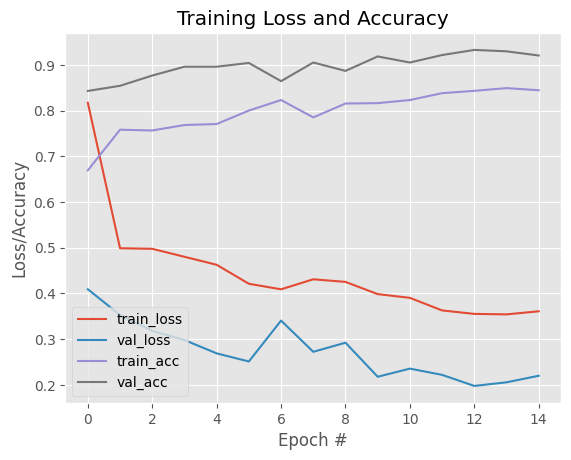

In [17]:
# plot the training loss and accuracy
print("\n[INFO] plotting stats...")
#N = EPOCHS_PARAM
N = len(history.history["loss"])
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), history.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), history.history["val_loss"], label="val_loss")
#plt.plot(np.arange(0, N), history.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), history.history["acc"], label="train_acc")
#plt.plot(np.arange(0, N), history.history["val_accuracy"], label="val_acc")
plt.plot(np.arange(0, N), history.history["val_acc"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig(plot_output_file)

plt.show()